### Imports

In [1]:
import functools
import os
import re
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

### Parameter definitions

In [3]:
DATA_DIR = Path(os.path.expanduser('~/jigsaw-toxic/data'))
JIGSAW_TOXIC_2017_DIR = DATA_DIR / 'jigsaw-toxic-comment-classification-challenge-2017'
JIGSAW_TOXIC_SEVERITY_RATING_DIR = DATA_DIR / 'jigsaw-toxic-severity-rating'
JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR = DATA_DIR / 'datasets/comment-classification-challenge-2017'

In [4]:
!ls -la $JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR

total 250796
drwxr-xr-x  2 jovyan users     4096 Dec 20 11:01 .
drwxr-xr-x 11 jovyan users     4096 Jan 26 19:03 ..
-rw-r--r--  1 jovyan users 35990358 Dec 15 13:21 train_v1_maxlen256.csv
-rw-r--r--  1 jovyan users 59669242 Dec 15 13:22 train_v1_maxlen512.csv
-rw-r--r--  1 jovyan users 69255825 Dec 20 10:58 train_v2.csv
-rw-r--r--  1 jovyan users 69324501 Dec 20 11:01 train_v3.csv
-rw-r--r--  1 jovyan users  8633656 Dec 15 11:18 valid.csv
-rw-r--r--  1 jovyan users 13924518 Dec 15 13:24 valid_v1.csv


### Exploration

In [7]:
!mkdir -p $JIGSAW_TOXIC_20211215_DIR

In [9]:
!cp $JIGSAW_TOXIC_SEVERITY_RATING_DIR/valid.csv $JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR/valid.csv

In [23]:
valid_df = pd.read_csv(str(JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR / 'valid.csv'))

In [24]:
valid_df

,less_toxic,more_toxic,certainty
0,"I think people say its not so absurd, because ...",Re Vandalism. . . . that is because the user ...,0.666667
1,You must have the lowest IQ of anyone on wikip...,Wha's a reliable source mike? Something that c...,1.000000
2,"Thanks for removing more of his anonymous, un...","To Bad\nyou dont have the balls to sign in, I ...",1.000000
3,"""\n\nActually, it clearly does not involve pow...",", 18 November 2006 (UTC)\n\nWell comrade. Look...",0.666667
4,You are not cool \n\nYou are the most hated f...,"""== Hey Fuck-head==\nHey, just wanted to say ""...",1.000000
...,...,...,...
10103,Heeeeeeeeeeeeeeyyyyyyyyyyyy dude! Sup!,you deleted my page \nand i am extrememly mad ...,1.000000
10104,ATTENTION:''''''\n\nANYONE WHO OPPOSES MY OPIN...,suck dick u disrespectful swearing wank!!,1.000000
10105,"Oh yah, and Bayerischermann is another guy try...",Thanks. Also thanks for freezing the article. ...,1.000000
10106,I had to chop out a section specifically compa...,"""\n\nHorrifyingly enough, """"ritualistic penis ...",0.666667


In [25]:
!ls -la $JIGSAW_TOXIC_2017_DIR

total 137144
drwxrwxr-x 2 jovyan 1001     4096 Dec  8 10:14 .
drwxrwxr-x 8 jovyan 1001     4096 Dec 15 11:18 ..
-rw-rw-r-- 1 jovyan 1001  6279782 Jun 19  2018 sample_submission.csv
-rw-r--r-- 1 jovyan 1001 60354593 Jan 18  2018 test.csv
-rw-rw-r-- 1 jovyan 1001  4976930 Jun 19  2018 test_labels.csv
-rw-r--r-- 1 jovyan 1001 68802655 Jan 18  2018 train.csv


In [4]:
train_2017_df = pd.read_csv(JIGSAW_TOXIC_2017_DIR / 'train.csv')
test_2017_df = pd.read_csv(JIGSAW_TOXIC_2017_DIR / 'test.csv')
test_2017_labels_df = pd.read_csv(JIGSAW_TOXIC_2017_DIR / 'test_labels.csv')

In [31]:
train_2017_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [32]:
test_2017_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [36]:
len(test_2017_labels_df[test_2017_labels_df['toxic'] == -1])

89186

### Text Cleaning

In [41]:
def _get_stop_words_eng():
    nltk.download('stopwords')
    return nltk.corpus.stopwords.words('english')


class TextCleaner:
    _STOP_WORDS_ENG = _get_stop_words_eng()

    _RE_WEBSITE_LINK = re.compile(r'https?://\S+|www\.\S+')
    _RE_EMOJI = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+', flags=re.UNICODE)
    _RE_SPECIAL_CHARACTERS = re.compile(r'[^a-zA-Z\d]')
    _RE_EXTRA_SPACES = re.compile(r' +')

    def __init__(self):
        pass

    def clean(self, text: str) -> str:
        """
        Cleans text into a basic form for NLP. Operations include the following:-
        1. Remove special charecters like &, #, etc
        2. Removes extra spaces
        3. Removes embedded URL links
        4. Removes HTML tags
        5. Removes emojis
        
        text - Text piece to be cleaned.
        """
        text = self._RE_WEBSITE_LINK.sub(r'', text)
        
        soup = BeautifulSoup(text, 'lxml')  # Removes HTML tags
        only_text = soup.get_text()
        text = only_text

        text = self._RE_EMOJI.sub(r'', text)
        
        text = self._RE_SPECIAL_CHARACTERS.sub(" ", text)  # Remove special Charecters
        text = self._RE_EXTRA_SPACES.sub(' ', text)  # Remove Extra Spaces
        text = text.strip()  # Remove spaces at the beginning and at the end of string

        # Remove stop words
        text = ' '.join([token for token in text.split(' ') if token.lower() not in self._STOP_WORDS_ENG])

        return text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
cleaner = TextCleaner()

In [7]:
def _generate_score_for_row(
        row: t.Dict[str, int],
        toxic_weight: float = 1.0,
        severe_toxic_weight: float = 2.5,
        obscene_weight: float = 1.0,
        threat_weight: float = 1.0,
        insult_weight: float = 1.0,
        identity_hate_weight: float = 1.0) -> float:
    score = row['toxic'] * toxic_weight + \
        row['severe_toxic'] * severe_toxic_weight + \
        row['obscene'] * obscene_weight + \
        row['threat'] * threat_weight + \
        row['insult'] * insult_weight + \
        row['identity_hate'] * identity_hate_weight
    return score / (
        toxic_weight + 
        severe_toxic_weight + 
        obscene_weight + 
        threat_weight + 
        insult_weight + 
        identity_hate_weight)

### V1 generation

In [55]:
train_2017_df['score'] = train_2017_df.progress_apply(_generate_score_for_row, axis=1)

  0%|          | 0/159571 [00:00<?, ?it/s]

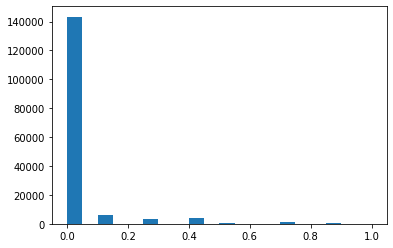

In [60]:
plt.hist(train_2017_df['score'], bins=20);

In [56]:
train_2017_df['comment_text_cleaned'] = train_2017_df['comment_text'].progress_apply(lambda text: cleaner.clean(text))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [57]:
train_2017_df['comment_text_cleaned_len'] = train_2017_df['comment_text_cleaned'].progress_apply(lambda text: len(text))

  0%|          | 0/159571 [00:00<?, ?it/s]

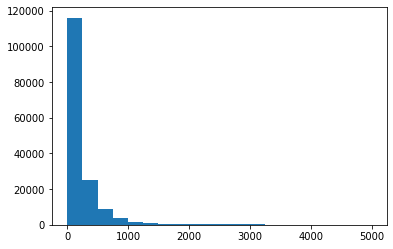

In [50]:
plt.hist(train_2017_df['comment_text_cleaned_len'], bins=20);

Percent of samples shorter than 256 chars:

In [46]:
len(train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 256]) / len(train_2017_df)

0.7352401125517795

Sample length distribution:

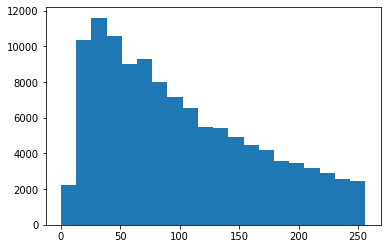

In [52]:
plt.hist(train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 256]['comment_text_cleaned_len'], bins=20);

Score distribution:

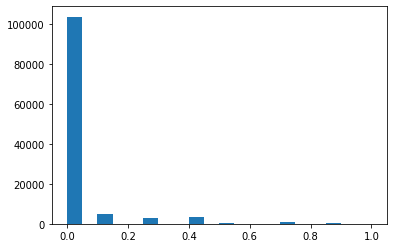

In [58]:
plt.hist(train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 256]['score'], bins=20);

In [62]:
train_2017_len256_df = train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 256]

In [64]:
len(train_2017_len256_df[train_2017_len256_df['score'] != 0.0]) / len(train_2017_len256_df)

0.11644775534208979

In [67]:
train_2017_len256_df.to_csv(JIGSAW_TOXIC_20211215_DIR / 'train_v1_maxlen256.csv', index=False)

Percent of samples shorter than 512 chars:

In [51]:
len(train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 512]) / len(train_2017_df)

0.8874168865270006

Sample length distribution:

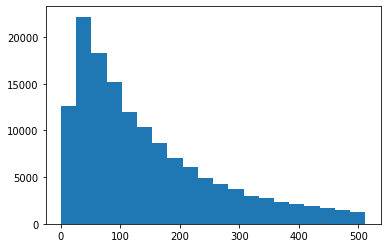

In [53]:
plt.hist(train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 512]['comment_text_cleaned_len'], bins=20);

Score distribution:

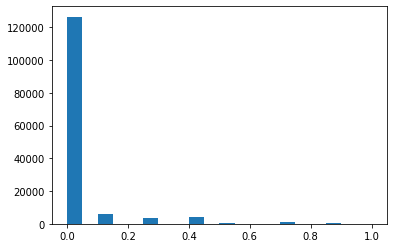

In [61]:
plt.hist(train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 512]['score'], bins=20);

In [65]:
train_2017_len512_df = train_2017_df[train_2017_df['comment_text_cleaned_len'] <= 512]

In [66]:
len(train_2017_len512_df[train_2017_len512_df['score'] != 0.0]) / len(train_2017_len512_df)

0.1071988475064616

In [68]:
train_2017_len512_df.to_csv(JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR / 'train_v1_maxlen512.csv', index=False)

In [69]:
valid_df['more_toxic_cleaned'] = valid_df['more_toxic'].progress_apply(lambda text: cleaner.clean(text))
valid_df['less_toxic_cleaned'] = valid_df['less_toxic'].progress_apply(lambda text: cleaner.clean(text))

  0%|          | 0/10108 [00:00<?, ?it/s]

  0%|          | 0/10108 [00:00<?, ?it/s]

In [71]:
valid_df.to_csv(JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR / 'valid_v1.csv', index=False)

### V2 generation

Same as V1 but:
1. Text is not cleaned or cut.

In [13]:
train_2017_df['score'] = train_2017_df.progress_apply(_generate_score_for_row, axis=1)

  0%|          | 0/159571 [00:00<?, ?it/s]

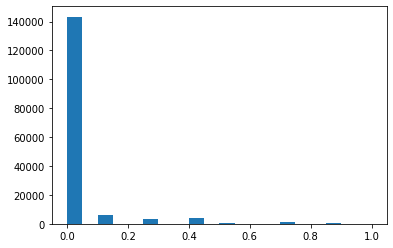

In [14]:
plt.hist(train_2017_df['score'], bins=20);

In [15]:
train_2017_df.to_csv(JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR / 'train_v2.csv', index=False)

### V3 generation

Same as V2 but:
1. Score generation function is different. See https://www.kaggle.com/toru59er/0-86-tfidf-ridge-simple-baseline

In [16]:
train_2017_df['score'] = train_2017_df.progress_apply(
    functools.partial(
        _generate_score_for_row,
        toxic_weight=0.32,
        severe_toxic_weight=1.5,
        obscene_weight=0.16,
        insult_weight=0.64,
        threat_weight=1.5,
        identity_hate_weight=1.5),
    axis=1)

  0%|          | 0/159571 [00:00<?, ?it/s]

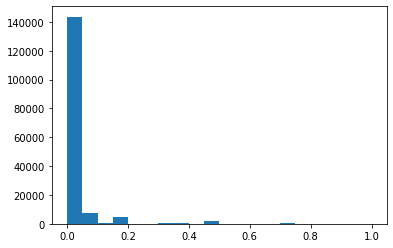

In [18]:
plt.hist(train_2017_df['score'], bins=20);

In [17]:
train_2017_df.to_csv(JIGSAW_TOXIC_COMMENT_CLASSIFICATION_CHALLENGE_DIR / 'train_v3.csv', index=False)